<a href="https://colab.research.google.com/github/agnani/DeepLearning/blob/master/Eurosat_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.3.2)


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [4]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [0]:
dataset, metadata = tfds.load('eurosat',as_supervised=True, with_info=True)
train_dataset = dataset['train']

In [0]:
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop',   'Residential',  'River',   'SeaLake']

In [21]:
num_train_examples = metadata.splits['train'].num_examples
#num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
#print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 27000


In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
#test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
#test_dataset  =  test_dataset.cache()

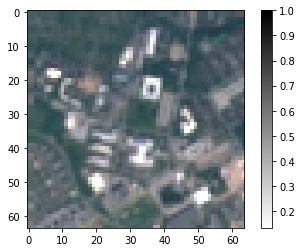

In [31]:
# Take a single image, and remove the color dimension by reshaping
for image, label in train_dataset.take(1):
  break
image = image.numpy().reshape((64,64,3))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

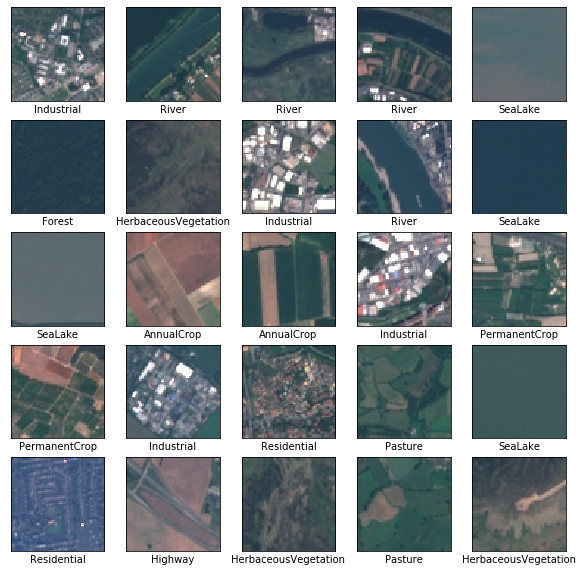

In [34]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in train_dataset.take(25):
    image = image.numpy().reshape((64,64,3))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
#test_dataset = test_dataset.batch(BATCH_SIZE)

In [38]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Train for 844 steps
Epoch 1/5
844/844 [==============================] - 16s 19ms/step - loss: 1.8833 - accuracy: 0.3071
Epoch 2/5
844/844 [==============================] - 10s 12ms/step - loss: 1.6328 - accuracy: 0.3940
Epoch 3/5
844/844 [==============================] - 10s 12ms/step - loss: 1.5937 - accuracy: 0.4064
Epoch 4/5
844/844 [==============================] - 10s 12ms/step - loss: 1.5565 - accuracy: 0.4273
Epoch 5/5
844/844 [==============================] - 10s 12ms/step - loss: 1.5524 - accuracy: 0.4265


In [0]:
#test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
#print('Accuracy on test dataset:', test_accuracy)

In [0]:
for test_images, test_labels in train_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [40]:
predictions.shape

(32, 10)

In [41]:
predictions[0]

array([6.6636041e-02, 5.9521375e-03, 1.3234007e-02, 8.0858372e-02,
       3.9341262e-07, 4.0453330e-01, 3.9455716e-02, 2.4832226e-03,
       3.4592780e-01, 4.0918902e-02], dtype=float32)

In [42]:
np.argmax(predictions[0])

5

In [44]:
test_labels[0]

5

In [0]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

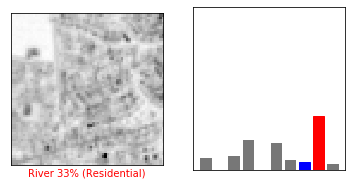

In [48]:
i = 30
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

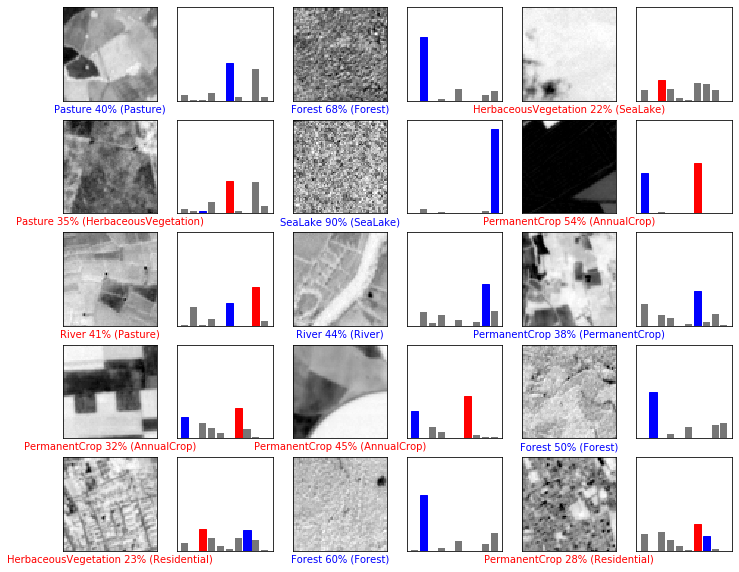

In [49]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


In [51]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(64, 64, 3)


In [52]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 64, 64, 3)


In [53]:
predictions_single = model.predict(img)

print(predictions_single)

[[6.6636071e-02 5.9521347e-03 1.3234008e-02 8.0858380e-02 3.9341245e-07
  4.0453351e-01 3.9455716e-02 2.4832205e-03 3.4592772e-01 4.0918939e-02]]


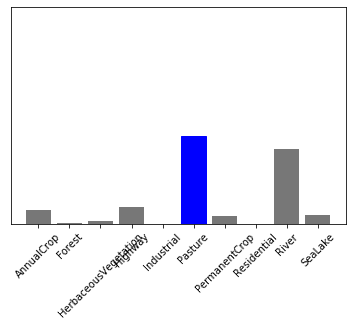

In [54]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [55]:
np.argmax(predictions_single[0])

5